# Cleaning, Extracting and ploting cardiac activity features

Heart rate is one of the most common physiological features. This notebook transforms Electrocardiogram recordings and Interbeat Interval timings into continuous heart rate.

## Cleaning 
Measurements from wearables often have moments of poor connection as sensors move during active wear. Before interpretating the sensor values its important to check if they are of sufficient quality.

## Extracting features - Heart Rate
Heart rate is not usually instantaneous value, it's an average over an interval of time. With these measurements, we can also evaluate heart rate locally to capture changes of rate in relationship to events. 

## Extracting features - Heart Rate Variability
Heart rate variability can be evaluated many ways (link to standards doc), from beat-to-beat variation (RMSSD) to frequency ranges (High Frequency, Low Frequency, Very Low, Ultra Low....). Looking at heart rate variability against activities restricts the type of calculation and exposes interactions with what people are doing.

In [ ]:
!git clone https://github.com/finn42/Beat_Breath_Workshop.git

Drag the qex.py module  and the mh.py into the main folder


In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import qex
import mh

In [3]:
demofile_loc = './Beat_Breath_Workshop/demodata/EQ/' #location for colab
df_datafiles = qex.qiosk_recordings(demofile_loc)
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,ECGloc,SubjectNames,SENSOR ID,SUBJECT ID,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,WW501,5022238,241203,4,DATA-WW501-5022238-24120304.CSV,csv,1816,2024-12-03 14:49:34+00:00,2024-12-03 14:54:19+00:00,...,./demodata/EQ/ECG-WW501-5022238-24120304.csv,[WW501],5022238.0,WW501,240.0,34.0,0.0,1.0,Stationary,Upright
1,DATA,LS402,5022204,241203,4,DATA-LS402-5022204-24120304.CSV,csv,1825,2024-12-03 14:49:35+00:00,2024-12-03 14:54:20+00:00,...,./demodata/EQ/ECG-LS402-5022204-24120304.csv,[LS402],5022204.0,LS402,77.0,98.0,0.0,0.0,MovingSlowly,Upright
2,DATA,WW501,5022238,241203,1,DATA-WW501-5022238-24120301.CSV,csv,2745,2024-12-03 17:29:34+00:00,2024-12-03 17:37:04+00:00,...,./demodata/EQ/ECG-WW501-5022238-24120301.csv,[WW501],5022238.0,WW501,131.0,97.0,0.0,0.0,Stationary,Upright
3,DATA,LS402,5022204,241203,1,DATA-LS402-5022204-24120301.CSV,csv,2717,2024-12-03 17:29:35+00:00,2024-12-03 17:37:05+00:00,...,./demodata/EQ/ECG-LS402-5022204-24120301.csv,[LS402],5022204.0,LS402,77.0,98.0,0.0,0.0,Stationary,Upright
4,DATA,WW501,5022238,241203,3,DATA-WW501-5022238-24120303.CSV,csv,8731,2024-12-03 20:30:04+00:00,2024-12-03 20:55:19+00:00,...,./demodata/EQ/ECG-WW501-5022238-24120303.csv,[WW501],5022238.0,WW501,101.0,99.0,0.0,0.0,Stationary,Upright
5,DATA,LS402,5022204,241203,3,DATA-LS402-5022204-24120303.CSV,csv,8646,2024-12-03 20:30:05+00:00,2024-12-03 20:55:20+00:00,...,./demodata/EQ/ECG-LS402-5022204-24120303.csv,[LS402],5022204.0,LS402,77.0,99.0,0.0,0.0,Stationary,Upright
6,DATA,WW501,5022238,241203,2,DATA-WW501-5022238-24120302.CSV,csv,4912,2024-12-03 20:55:04+00:00,2024-12-03 21:08:49+00:00,...,./demodata/EQ/ECG-WW501-5022238-24120302.csv,[WW501],5022238.0,WW501,122.0,98.0,0.0,0.0,MovingSlowly,Upright
7,DATA,LS402,5022204,241203,2,DATA-LS402-5022204-24120302.CSV,csv,4882,2024-12-03 20:55:05+00:00,2024-12-03 21:08:50+00:00,...,./demodata/EQ/ECG-LS402-5022204-24120302.csv,[LS402],5022204.0,LS402,82.0,98.0,0.0,0.0,MovingSlowly,Upright


# Cleaning Cardiac Recordings
Measurements with wearable devices in active conditions are always at risk of having contact noise and motion artifacts obscure cardiac measurements. Before evaluating the signal, we have to assess for quality and clear out incorrectly identified heart beats.


In [4]:
recID =2
V = pd.read_csv(df_datafiles.loc[recID,'ECGloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
ECG = V.set_index('Time_s')

V = pd.read_csv(df_datafiles.loc[recID,'RRloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
IBI = V.set_index('Time_s')

# show the second-wise index, an uneven sample rate, reporting beat timing
print(IBI.iloc[:5,:])
# show the second-wise index, a rapid sample rate, 256 Hz
print(ECG.iloc[:5,:])

                               DateTime  Interbeat Interval (MS)
Time_s                                                          
0.000  2024-12-03 17:29:31.871000+00:00                      468
0.468  2024-12-03 17:29:32.339000+00:00                      468
0.976  2024-12-03 17:29:32.847000+00:00                      472
1.445  2024-12-03 17:29:33.316000+00:00                      472
1.914  2024-12-03 17:29:33.785000+00:00                      472
                               DateTime    Lead 1    Lead 2
Time_s                                                     
0.000  2024-12-03 17:29:31.617000+00:00 -0.043956 -0.076923
0.004  2024-12-03 17:29:31.621000+00:00 -0.054945 -0.065934
0.007  2024-12-03 17:29:31.624000+00:00 -0.076923 -0.098901
0.011  2024-12-03 17:29:31.628000+00:00 -0.076923 -0.120879
0.015  2024-12-03 17:29:31.632000+00:00 -0.054945 -0.109890


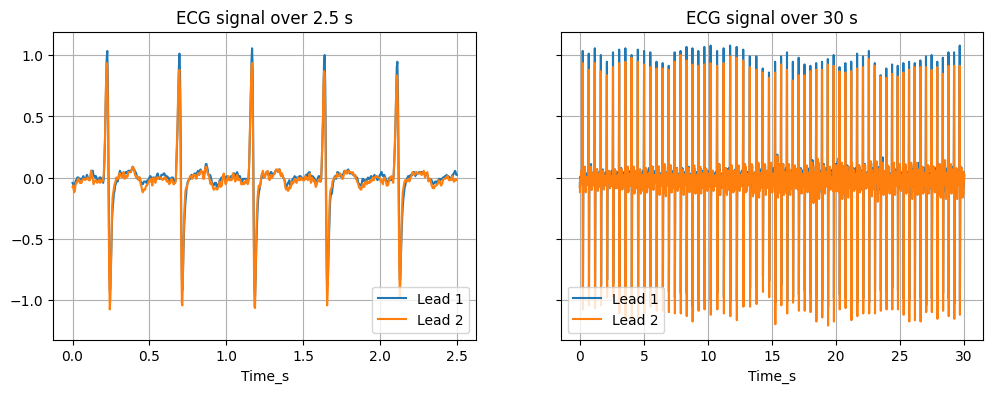

In [5]:
fig,(axes) = plt.subplots(1,2,figsize=(12,4),sharey=True)
ECG.loc[:2.50,['Lead 1','Lead 2']].plot(ax = axes[0])
axes[0].set(title = 'ECG signal over 2.5 s')
axes[0].grid()
ECG.loc[:30.0,['Lead 1','Lead 2']].plot(ax = axes[1])
axes[1].set(title = 'ECG signal over 30 s')
axes[1].grid()
plt.show()

These excerpts of this recording look clean enough to trust the Interbeat Intervals evaluated by the Equivital system (RR). 

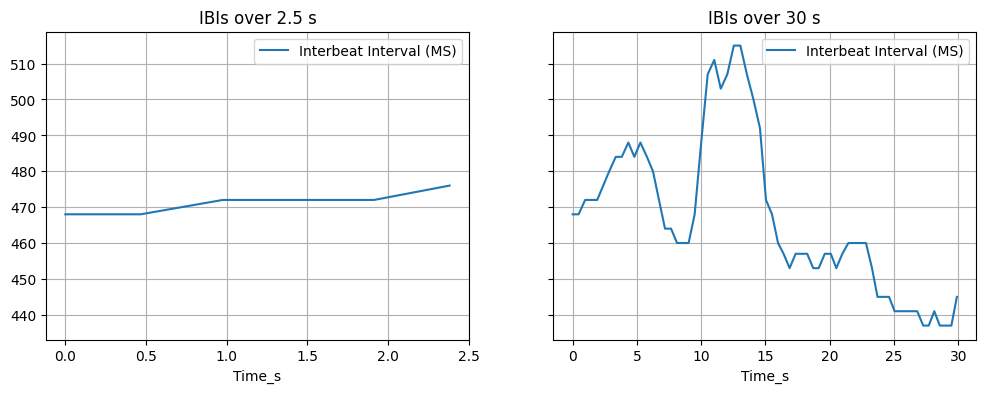

In [6]:
fig,(axes) = plt.subplots(1,2,figsize=(12,4),sharey=True)
IBI.loc[:2.50,['Interbeat Interval (MS)']].plot(ax = axes[0])
axes[0].set(title = 'IBIs over 2.5 s')
axes[0].grid()
IBI.loc[:30.0,['Interbeat Interval (MS)']].plot(ax = axes[1])
axes[1].set(title = 'IBIs over 30 s')
axes[1].grid()
plt.show()

This looks like a good cardiac recordings: Clear spikes in the ECG signals and Interbeat intervals in a reasonable range: 450 ms to 512 ms corresponds to heart rates between 117 BPM and 133 BPM. This is the heart rate of a human adult in action.

### example of a bad recording: no contact
This recording excerpt was from a belt that was not being worn. The ECG signal doesn't looke like a heart beat when zoomed in, and the IBI values are nonesenses

In [7]:
recID =0
V = pd.read_csv(df_datafiles.loc[recID,'ECGloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
ECG = V.set_index('Time_s')

V = pd.read_csv(df_datafiles.loc[recID,'RRloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
IBI = V.set_index('Time_s')

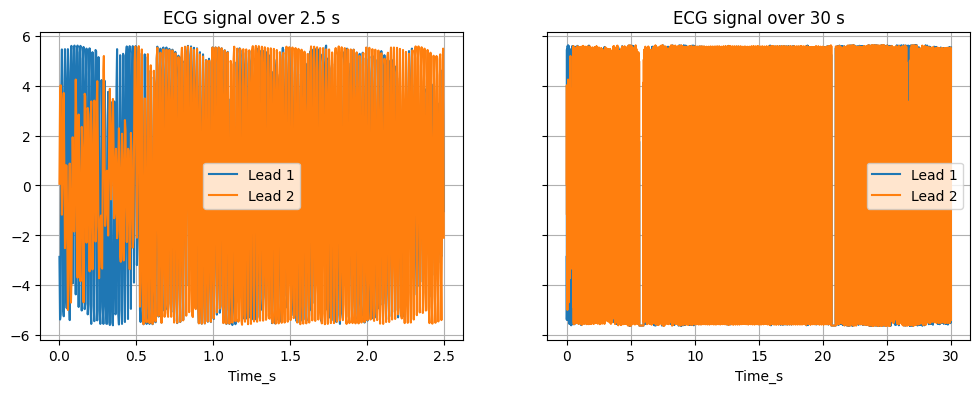

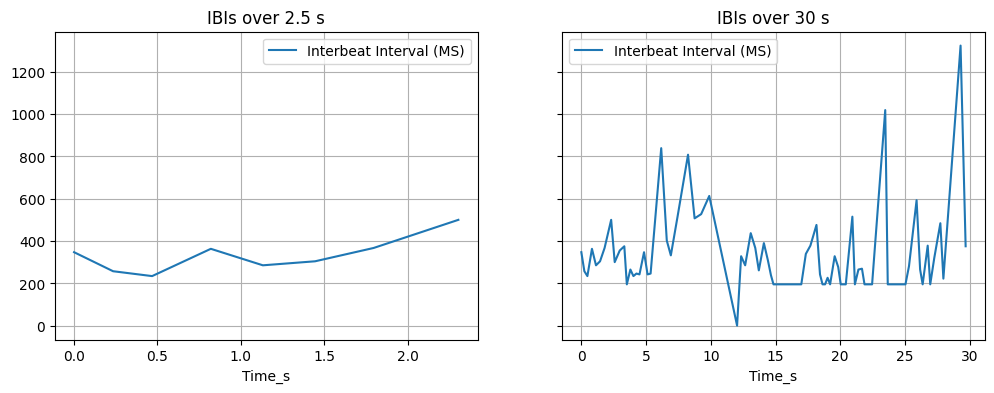

In [8]:
fig,(axes) = plt.subplots(1,2,figsize=(12,4),sharey=True)
ECG.loc[:2.50,['Lead 1','Lead 2']].plot(ax = axes[0])
axes[0].set(title = 'ECG signal over 2.5 s')
axes[0].grid()
ECG.loc[:30.0,['Lead 1','Lead 2']].plot(ax = axes[1])
axes[1].set(title = 'ECG signal over 30 s')
axes[1].grid()
plt.show()

fig,(axes) = plt.subplots(1,2,figsize=(12,4),sharey=True)
IBI.loc[:2.50,['Interbeat Interval (MS)']].plot(ax = axes[0])
axes[0].set(title = 'IBIs over 2.5 s')
axes[0].grid()
IBI.loc[:30.0,['Interbeat Interval (MS)']].plot(ax = axes[1])
axes[1].set(title = 'IBIs over 30 s')
axes[1].grid()
plt.show()

This recording doesn't have a cardiac signal, just noise. For awake human adults, the Interbeat intervals (here in milliseconds) are generally between 330 ms (180 BPM) and 1200 ms (50 BPM), and the change is rarely so dramatic as shown here. 

There is not point in trying to clean this recording because there is no cardiac signal to be found (vest was off).

### example of a bad recording: Intermittent electrode noise
This recording features frequent deviation that look like intermittent noise in the electrods resulting in false beats being recorded. These deviant beats can be filterted out of the IBI recordings (RR).

In [9]:
recID =2
V = pd.read_csv(df_datafiles.loc[recID,'ECGloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
ECG = V.set_index('Time_s')

V = pd.read_csv(df_datafiles.loc[recID,'RRloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
IBI = V.set_index('Time_s')


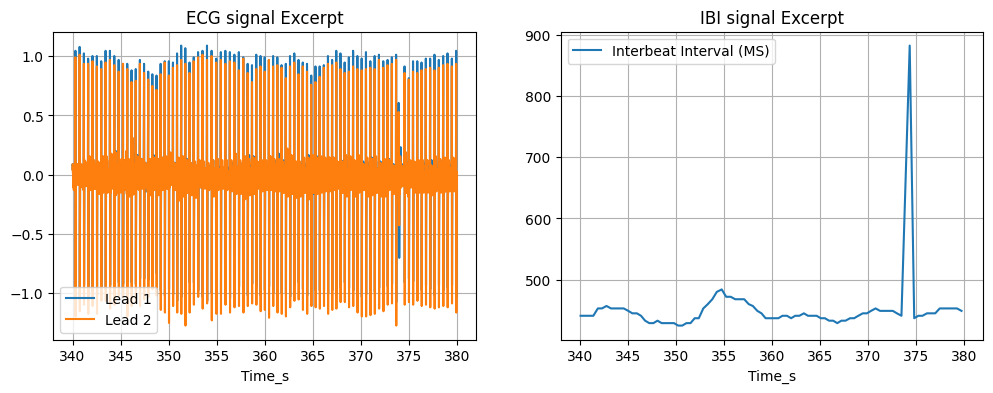

In [10]:
fig,(axes) = plt.subplots(1,2,figsize=(12,4),sharex=True)
ECG.loc[340:380,['Lead 1','Lead 2']].plot(ax = axes[0])
axes[0].set(title = 'ECG signal Excerpt')
axes[0].grid()
IBI.loc[340:380,['Interbeat Interval (MS)']].plot(ax = axes[1])
axes[1].set(title = 'IBI signal Excerpt')
axes[1].grid()
plt.show()

This recording does have a cardiac signal but there are busts of noise in the ECG recordings that are producing weird deviations in the IBI values. This signal can be cleaned. 

In [11]:
rec_tag = 'Noisy cardiac measurement'
sig_ex = rec_tag
sig_t = V['Time_s']
sig_v = V['Interbeat Interval (MS)']

cIBI=mh.clean_IBI(sig_t,sig_v,activitytype='default')
newIBI = mh.contact_noise_cut(ECG.index,ECG['Lead 1'].values,sig_t,sig_v,0.3)

newV = V.loc[newIBI.index,:]
newIBI=mh.clean_IBI(newV['Time_s'],newV['Interbeat Interval (MS)'],activitytype='default')
# newIBI


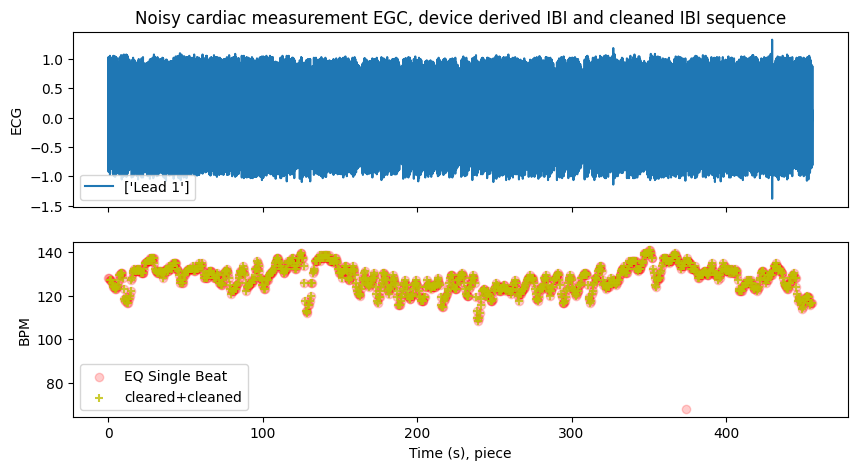

In [13]:
fig, (ax) = plt.subplots(2, 1,figsize = [10,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='EQ Single Beat')
ax[1].scatter(x = newIBI.index,y = (60000/newIBI['IBI']),color='y',marker = '+',alpha = 0.8,label='cleared+cleaned')

ax[1].set_ylabel('BPM')
ax[0].plot(ECG.index,ECG['Lead 1'].values,label=['Lead 1'])

ax[0].set_ylabel('ECG')
ax[1].set_xlabel('Time (s), piece')
ax[0].legend()
ax[1].legend()
ax[0].set_title(rec_tag+' EGC, device derived IBI and cleaned IBI sequence')
# plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','Resp'])+'.png',dpi=mydpi)

plt.show()

The above plot shows the full ECG signal, with spikes showing some of the deviations but not all, and then the IBI sequence translated into instantaneous heart rate with all the original values (red circles) and the cleaned version marked by yellow crosses.  The only difference between these two recordings is the red dot before 400 s. The cleaning heuristic algorithm is designed to preserved as much real signal as possible despite these common issues.

This cleaned IBI sequence can now be studied for action related cardiac changes without the interference of contact noise or (mostly irrelevant) irregular beats.

In [14]:
newIBI_loc = './outdata/'+df_datafiles.loc[recID,'RRloc'].split('/')[-1].split('.')[0]+'_Cleaned.CSV'
newIBI.to_csv(newIBI_loc)

# Cardiac feature: Heart Rate
Heart rate is usually measured over an interval time: 15 s, 1 minute, 5 minutes. When looking at cardiac activity against concurrent activities, it's sometimes relevant to have a more local evaluation of heart rate. The ibi_sbeatfeats function offers heart rate evaluated per beat (HR1bt) or the average over 10 seconds (HR10s) or the average over 30s (HR30s).

In [15]:
recID=4

V = pd.read_csv(df_datafiles.loc[recID,'ECGloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
ECG = V.set_index('Time_s')
V = pd.read_csv(df_datafiles.loc[recID,'RRloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()

cIBI=mh.clean_IBI(V['Time_s'],V['Interbeat Interval (MS)'],activitytype='default')
newIBI = mh.contact_noise_cut(ECG.index,ECG['Lead 1'].values,V['Time_s'],V['Interbeat Interval (MS)'],0.3)

newV = V.loc[newIBI.index,:]
newIBI=mh.clean_IBI(newV['Time_s'],newV['Interbeat Interval (MS)'],activitytype='default')
df_Card = mh.ibi_sbeatfeats(newIBI.index,newIBI['IBI'].values)

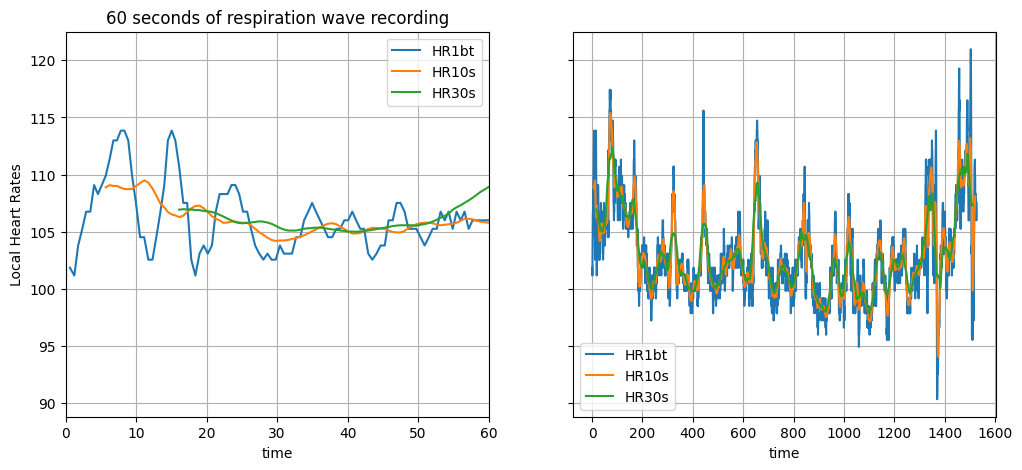

In [16]:
fig,(axes) = plt.subplots(1,2,figsize=(12,5),sharey=True)
df_Card[['HR1bt', 'HR10s', 'HR30s']].loc[:60,:].plot(ax = axes[0])
axes[0].grid()
axes[0].set(xlim=[0,60],ylabel = 'Local Heart Rates', title = '60 seconds of respiration wave recording')

df_Card[['HR1bt', 'HR10s', 'HR30s']].plot(ax = axes[1])
axes[1].grid()
plt.show()
# mh.hrv_feats(sig_t,sig_v,time_s)

That looks like heart rate values over time. The effect of averaging heart rate over time is shown most clearly in the 60 second excerpt, but it also trims the extremes over longer intervals too. 

## Heart rate against event information: Concert Listening

In [17]:
Events = pd.read_csv('./demodata/timing/Concert_Events_Structure.csv')

Events['Duration']=Events['TIME'].diff().shift(-1)
events_pallet = {'Applause':'red', 'Speech':'blue', 'Prime':'green', 'Music':'yellow'}

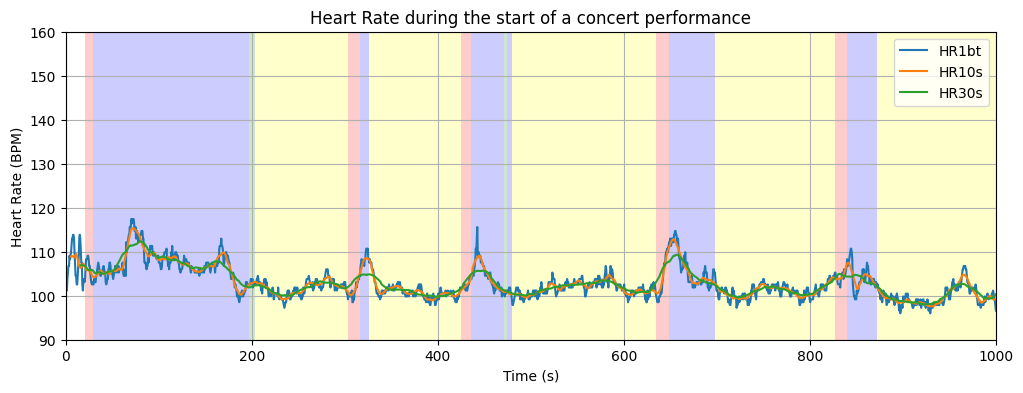

In [18]:
fig,(ax) = plt.subplots(1,1,figsize=(12,4),sharey=True)
df_Card[['HR1bt', 'HR10s', 'HR30s']].plot(ax = ax)
ax.grid()
for i,row in Events.iloc[:20,:].iterrows():
    ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['LABEL']],alpha = 0.2)
ax.set(xlim = [0,1000],ylim = [90,160],ylabel='Heart Rate (BPM)',xlabel = 'Time (s)')
plt.title('Heart Rate during the start of a concert performance') 
plt.show()

For this participant, their heart rate stabilised relatively low during the music intervals (yellow) and crested with applause, which often also featured vocal cheering. 


## Heart rate against event information: Dancing Lesson

In [19]:
Events = pd.read_csv('./demodata/timing/Dancing_Events_Structure.csv')
Events = Events.loc[Events.Structure.str.len()>0,:].copy()
Events['Duration']=Events['TIME'].diff().shift(-1)
events_pallet = {'D':'blue','T':'green','M':'yellow','A':'red', }

In [20]:
recID = 6
V = pd.read_csv(df_datafiles.loc[recID,'ECGloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
ECG = V.set_index('Time_s')
V = pd.read_csv(df_datafiles.loc[recID,'RRloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()

cIBI=mh.clean_IBI(V['Time_s'],V['Interbeat Interval (MS)'],activitytype='default')
newIBI = mh.contact_noise_cut(ECG.index,ECG['Lead 1'].values,V['Time_s'],V['Interbeat Interval (MS)'],0.3)

newV = V.loc[newIBI.index,:]
newIBI=mh.clean_IBI(newV['Time_s'],newV['Interbeat Interval (MS)'],activitytype='default')
df_Card = mh.ibi_sbeatfeats(newIBI.index,newIBI['IBI'].values)

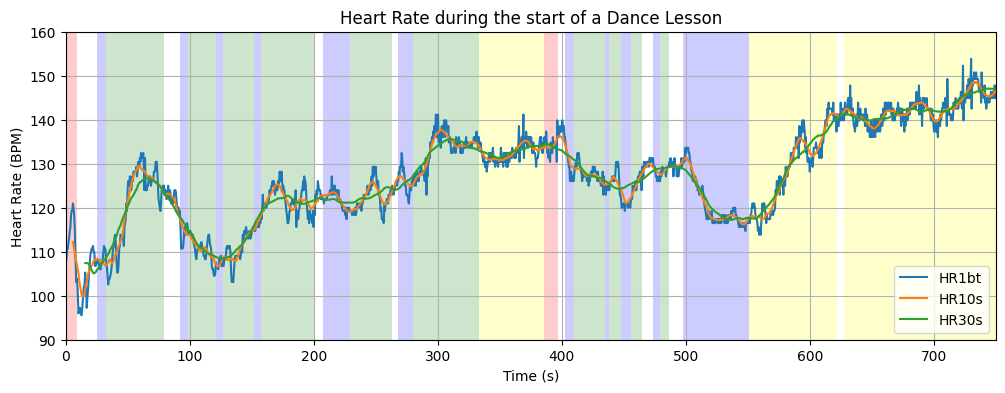

In [21]:
fig,(ax) = plt.subplots(1,1,figsize=(12,4),sharey=True)
df_Card[['HR1bt', 'HR10s', 'HR30s']].plot(ax = ax)
ax.grid()
for i,row in Events.iloc[:35,:].iterrows():
    if row['Structure'][0] in events_pallet.keys():
        ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['Structure'][0]],alpha = 0.2)
ax.set(xlim = [0,750],ylim = [90,160],ylabel='Heart Rate (BPM)',xlabel = 'Time (s)')
plt.title('Heart Rate during the start of a Dance Lesson') 
plt.show()

Heart rate during the dance lesson varied widely, increasing during tasks and while dancing to music and dropping when the instructor took the time to verbally contextualise the action to come (500). Some of these heart rate increases are due to physical activity, but others are more an expression of social stress, such as around 30s to 90s, when the participant was tasked with finding a dance partner for the lesson. 

## Heart rate against event information: Singing

In [22]:
Events = pd.read_csv('./demodata/timing/Singing_Events_Structure.csv')
Events
Events = Events.loc[Events.Type.str.len()>0,:].copy()
Events['Duration']=Events['TIME'].diff().shift(-1)
events_pallet = {'D':'blue','T':'green','M':'yellow','A':'red', }

In [23]:
recID = 2
V = pd.read_csv(df_datafiles.loc[recID,'ECGloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
ECG = V.set_index('Time_s')
V = pd.read_csv(df_datafiles.loc[recID,'RRloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()

cIBI=mh.clean_IBI(V['Time_s'],V['Interbeat Interval (MS)'],activitytype='default')
newIBI = mh.contact_noise_cut(ECG.index,ECG['Lead 1'].values,V['Time_s'],V['Interbeat Interval (MS)'],0.3)

newV = V.loc[newIBI.index,:]
newIBI=mh.clean_IBI(newV['Time_s'],newV['Interbeat Interval (MS)'],activitytype='default')
df_Card = mh.ibi_sbeatfeats(newIBI.index,newIBI['IBI'].values)

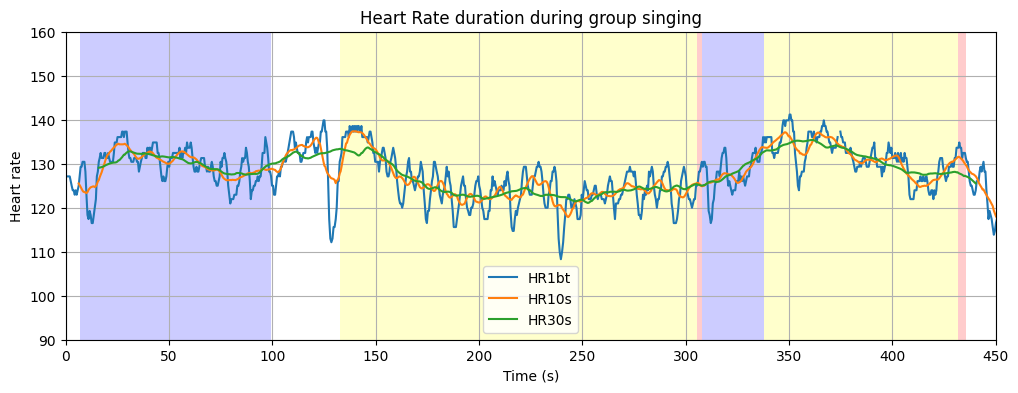

In [24]:
fig,(ax) = plt.subplots(1,1,figsize=(12,4),sharey=True)
df_Card[['HR1bt', 'HR10s', 'HR30s']].plot(ax = ax)
ax.grid()
for i,row in Events.iloc[:35,:].iterrows():
    if row['Type'][0] in events_pallet.keys():
        ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['Type'][0]],alpha = 0.2)
ax.set(xlim = [0,450],ylim = [90,160],ylabel='Heart rate',xlabel = 'Time (s)')
plt.title('Heart Rate duration during group singing') 
plt.show()

During this singing activity, this participant was conducting the group as well as vocalisting, which explains the high heart rate before the singing began. During one corale, heart rate varied hugely, cresting with every line, while during the other, the cycle wasn't as sweeping because the faster tempo and more complex arrangement. 

# Cardiac feature: Heart Rate Variability
Heart rate variability is a quality of cardiac activity typically measured over minutes, but recent research has looked for higher resolution strategies to capture changes in heart rate that could be connected to changes in subjective expriences and empathetic influences in social situations. 

These cardiac activity functions include hyperlocal calculations of Heart Rate Variability with a 10 and 30 beat version of RRMSD. This calculation should be enough to differentiate some conditions, but it also exposes the kinds of action related cardiac variation that often confounds this popular but controversial measurement.

In [25]:
recID=4

V = pd.read_csv(df_datafiles.loc[recID,'ECGloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
ECG = V.set_index('Time_s')
V = pd.read_csv(df_datafiles.loc[recID,'RRloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()

cIBI=mh.clean_IBI(V['Time_s'],V['Interbeat Interval (MS)'],activitytype='default')
newIBI = mh.contact_noise_cut(ECG.index,ECG['Lead 1'].values,V['Time_s'],V['Interbeat Interval (MS)'],0.3)

newV = V.loc[newIBI.index,:]
newIBI=mh.clean_IBI(newV['Time_s'],newV['Interbeat Interval (MS)'],activitytype='default')

df_Card = mh.hrv_beatfeats(newIBI.index,newIBI['IBI'])

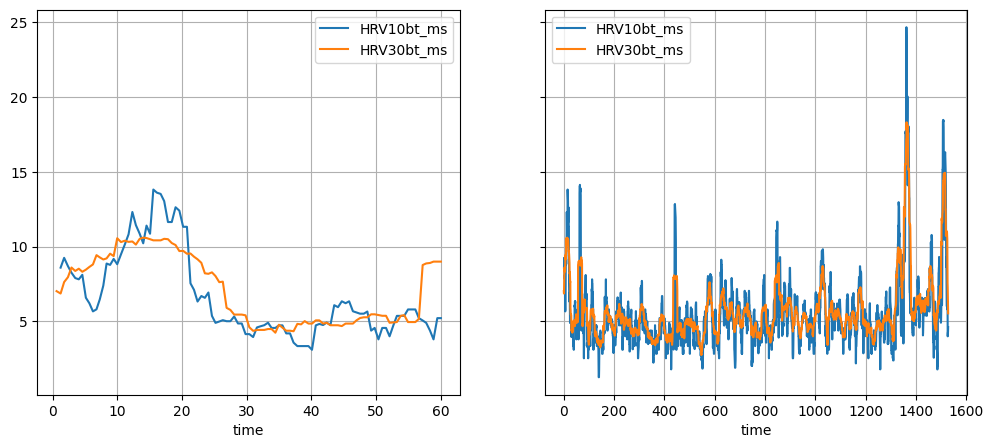

In [26]:
fig,(axes) = plt.subplots(1,2,figsize=(12,5),sharey=True)
df_Card[['HRV10bt_ms','HRV30bt_ms']].loc[:60,:].plot(ax = axes[0])
axes[0].grid()
df_Card[['HRV10bt_ms','HRV30bt_ms']].plot(ax = axes[1])
axes[1].grid()
plt.show()


## Heart rate variability against event information: Concert Listening

In [27]:
Events = pd.read_csv('./demodata/timing/Concert_Events_Structure.csv')

Events['Duration']=Events['TIME'].diff().shift(-1)
events_pallet = {'Applause':'red', 'Speech':'blue', 'Prime':'green', 'Music':'yellow'}

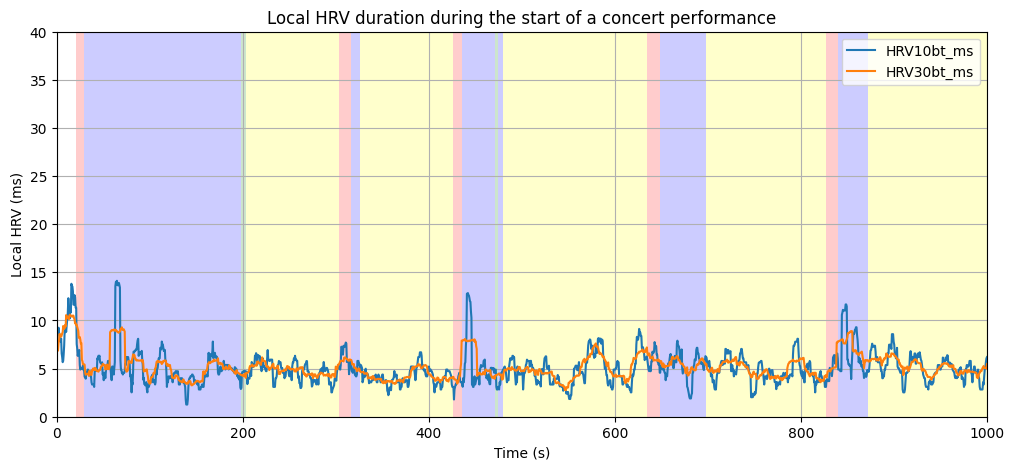

In [28]:
fig,(ax) = plt.subplots(1,1,figsize=(12,5),sharey=True)
df_Card[['HRV10bt_ms','HRV30bt_ms']].plot(ax = ax)
ax.grid()
for i,row in Events.iloc[:22,:].iterrows():
    ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['LABEL']],alpha = 0.2)
ax.set(xlim = [0,1000],ylim = [0,40],ylabel='Local HRV (ms)',xlabel = 'Time (s)')
plt.title('Local HRV duration during the start of a concert performance') 
plt.show()

The moments of local HRV increase are also moments when heart rate changed with a change of participant behaviour, from sitting quietly to clapping and cheering. Intermittent actions can produce artifacts that look like substantial changes in HRV but are clearly driven by specific actions.

## Heart rate variablity against event information: Dancing Lesson

In [29]:
Events = pd.read_csv('./demodata/timing/Dancing_Events_Structure.csv')
Events = Events.loc[Events.Structure.str.len()>0,:].copy()
Events['Duration']=Events['TIME'].diff().shift(-1)
events_pallet = {'D':'blue','T':'green','M':'yellow','A':'red', }

In [30]:
recID=6

V = pd.read_csv(df_datafiles.loc[recID,'ECGloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
ECG = V.set_index('Time_s')
V = pd.read_csv(df_datafiles.loc[recID,'RRloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()

cIBI=mh.clean_IBI(V['Time_s'],V['Interbeat Interval (MS)'],activitytype='default')
newIBI = mh.contact_noise_cut(ECG.index,ECG['Lead 1'].values,V['Time_s'],V['Interbeat Interval (MS)'],0.3)

newV = V.loc[newIBI.index,:]
newIBI=mh.clean_IBI(newV['Time_s'],newV['Interbeat Interval (MS)'],activitytype='default')

df_Card = mh.hrv_beatfeats(newIBI.index,newIBI['IBI'])

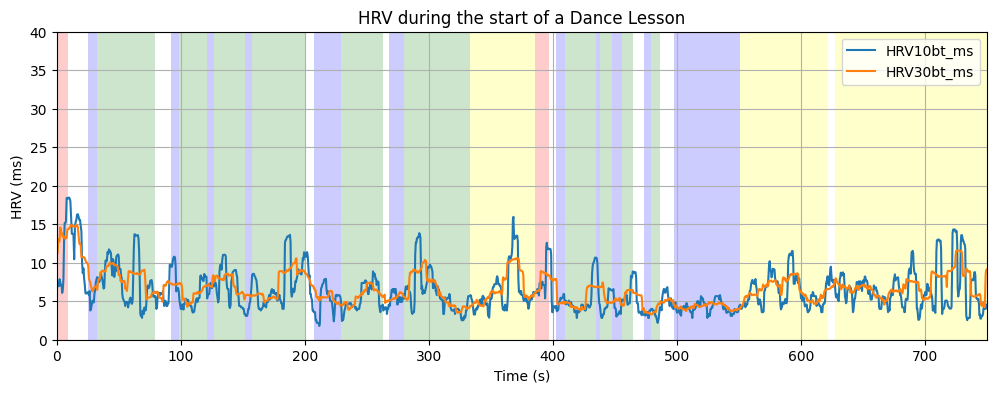

In [31]:
fig,(ax) = plt.subplots(1,1,figsize=(12,4),sharey=True)
df_Card[['HRV10bt_ms','HRV30bt_ms']].plot(ax = ax)
ax.grid()
for i,row in Events.iloc[:35,:].iterrows():
    if row['Structure'][0] in events_pallet.keys():
        ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['Structure'][0]],alpha = 0.2)
ax.set(xlim = [0,750],ylim = [0,40],ylabel='HRV (ms)',xlabel = 'Time (s)')
plt.title('HRV during the start of a Dance Lesson') 
plt.show()

## Heart rate variablity against event information: Singing

In [32]:
Events = pd.read_csv('./demodata/timing/Singing_Events_Structure.csv')
Events
Events = Events.loc[Events.Type.str.len()>0,:].copy()
Events['Duration']=Events['TIME'].diff().shift(-1)
events_pallet = {'D':'blue','T':'green','M':'yellow','A':'red', }

In [33]:
recID=2

V = pd.read_csv(df_datafiles.loc[recID,'ECGloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
ECG = V.set_index('Time_s')
V = pd.read_csv(df_datafiles.loc[recID,'RRloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()

cIBI=mh.clean_IBI(V['Time_s'],V['Interbeat Interval (MS)'],activitytype='default')
newIBI = mh.contact_noise_cut(ECG.index,ECG['Lead 1'].values,V['Time_s'],V['Interbeat Interval (MS)'],0.3)

newV = V.loc[newIBI.index,:]
newIBI=mh.clean_IBI(newV['Time_s'],newV['Interbeat Interval (MS)'],activitytype='default')

df_Card = mh.hrv_beatfeats(newIBI.index,newIBI['IBI'])

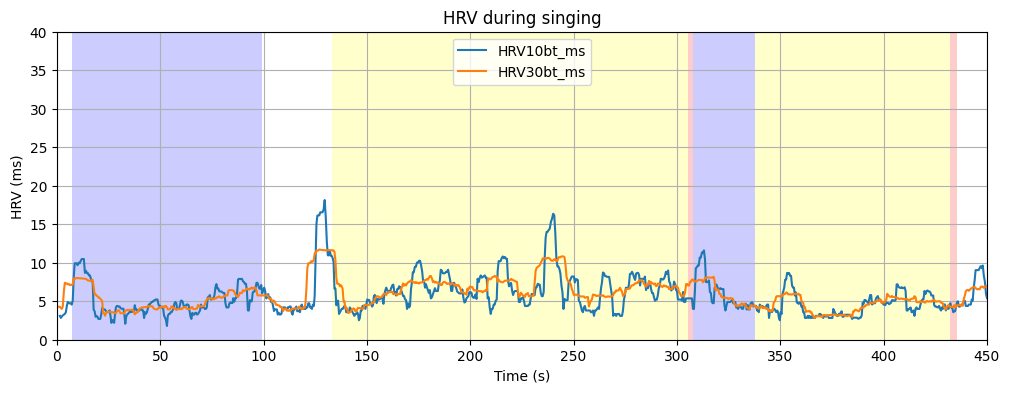

In [34]:
fig,(ax) = plt.subplots(1,1,figsize=(12,4),sharey=True)
df_Card[['HRV10bt_ms','HRV30bt_ms']].plot(ax = ax)
ax.grid()
for i,row in Events.iloc[:35,:].iterrows():
    if row['Type'][0] in events_pallet.keys():
        ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['Type'][0]],alpha = 0.2)
ax.set(xlim = [0,450],ylim = [0,40],ylabel='HRV (ms)',xlabel = 'Time (s)')
plt.title('HRV during singing') 
plt.show()

Baring other factors, Heart rate variability varies closely with heart rate. With this last singing example, we have a higher heart rate producing large variability because of interactions with the extreme respiratory demands of singing, with a sensitivity to the phrase length of the music.